#### Libraries

In [268]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/albayerga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [269]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import math
import numpy as np
import pandas as pd
import collections
from numpy import linalg as la
import matplotlib.pyplot as plt

#### Load data into memory


In [270]:
docs_path = 'data/farmers-protest-tweets.json'

In [302]:
original_data_tweets = pd.read_json(docs_path, lines=True)
print("The number of tweets in the dataset is: ", len(original_data_tweets))

The number of tweets in the dataset is:  117407


#### Extract fields Tweet | Date | Hashtags| Likes | Retweets | Url


In [309]:
data_tweets = original_data_tweets[['content', 'date', 'likeCount', 'retweetCount', 'url', 'lang']]
data_tweets.columns = ['Tweet', 'Date', 'Likes', 'Retweets', 'Url', 'Language'] # rename columns
data_tweets['Hashtags'] = data_tweets['Tweet'].apply(lambda x: [i for i in x.split() if i.startswith("#")]) # add a column for hashtags
data_tweets.head()

/var/folders/f3/l5b9z7s17xn7qbzqvq11y71m0000gn/T/ipykernel_60619/3440560551.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_tweets['Hashtags'] = data_tweets['Tweet'].apply(lambda x: [i for i in x.split() if i.startswith("#")]) # add a column for hashtags


,Tweet,Date,Likes,Retweets,Url,Language,Hashtags
0,The world progresses while the Indian police a...,2021-02-24 09:23:35+00:00,0,0,https://twitter.com/ArjunSinghPanam/status/136...,en,"[#ModiDontSellFarmers, #FarmersProtest, #FreeN..."
1,#FarmersProtest \n#ModiIgnoringFarmersDeaths \...,2021-02-24 09:23:32+00:00,0,0,https://twitter.com/PrdeepNain/status/13645062...,en,"[#FarmersProtest, #ModiIgnoringFarmersDeaths, ..."
2,ਪੈਟਰੋਲ ਦੀਆਂ ਕੀਮਤਾਂ ਨੂੰ ਮੱਦੇਨਜ਼ਰ ਰੱਖਦੇ ਹੋਏ \nਮੇ...,2021-02-24 09:23:22+00:00,0,0,https://twitter.com/parmarmaninder/status/1364...,pa,[#FarmersProtest]
3,@ReallySwara @rohini_sgh watch full video here...,2021-02-24 09:23:16+00:00,0,0,https://twitter.com/anmoldhaliwal/status/13645...,en,"[#farmersprotest, #NoFarmersNoFood]"
4,#KisanEktaMorcha #FarmersProtest #NoFarmersNoF...,2021-02-24 09:23:10+00:00,0,0,https://twitter.com/KotiaPreet/status/13645061...,und,"[#KisanEktaMorcha, #FarmersProtest, #NoFarmers..."


In [273]:
for i in range(1):
    print(data_tweets.iloc[i]['Tweet'])

The world progresses while the Indian police and Govt are still trying to take India back to the horrific past through its tyranny. 

@narendramodi @DelhiPolice Shame on you. 

#ModiDontSellFarmers 
#FarmersProtest 
#FreeNodeepKaur https://t.co/es3kn0IQAF


#### Implement a language dictionary to process stop words depending on the language of the tweet

In [300]:
# these are the unique larnguages in the dataset
print(original_data_tweets['lang'].unique())

['en' 'pa' 'und' 'hi' 'ta' 'hu' 'ur' 'et' 'mr' 'tl' 'es' 'de' 'in' 'or'
 'kn' 'ml' 'ht' 'it' 'fr' 'bn' 'sv' 'tr' 'gu' 'te' 'da' 'pt' 'cs' 'sl'
 'nl' 'ca' 'no' 'cy' 'pl' 'eu' 'ne' 'ru' 'lv' 'lt' 'fi' 'ro' 'ar' 'fa'
 'vi' 'is' 'ja' 'si']


In [301]:
language_dict = {
    'ar': 'arabic',
    'eu': 'basque',
    'bn': 'bengali',
    'ca': 'catalan',
    'da': 'danish',
    'nl': 'dutch',
    'en': 'english',
    'fi': 'finnish',
    'fr': 'french',
    'de': 'german',
    'hu': 'hungarian',
    'in': 'indonesian',
    'it': 'italian',
    'ne': 'nepali',
    'no': 'norwegian',
    'pt': 'portuguese',
    'ro': 'romanian',
    'ru': 'russian',
    'es': 'spanish',
    'sv': 'swedish',
    'tr': 'turkish'
}

#### 1. Pre-process document

In [305]:
import string
def build_terms(line, lang):

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words(lang)) # get the stop words for the language

    line = line.lower()  # everything to lowercase
    translator = str.maketrans('', '', string.punctuation)
    line = line.translate(translator)  # remove punctuation

    line= line.split() # tokenize the text, get a list of terms
    line= [word for word in line if word not in stop_words] # remove stop_words
    line= [stemmer.stem(word) for word in line ] # steam
    line = [word for word in line if word.isalnum()]  # keeps only words with alphanumeric characters

    return line

In [306]:
terms = build_terms("hello my #name is @john. I am a student, #student, ¢¢¢¢¢", 'english')
print(terms)

['hello', 'name', 'john', 'student', 'student']


In [313]:
# input: dataset of tweets, output: preprocessed dataset of tweets
# for each tweet content - build terms (stop words depend on the language)
def preprocess_document(tweets):
    preprocessed_document = tweets.copy() # copy to avoid modifying the original dataset

    for i in range(len(preprocessed_document)):
        twt_content = preprocessed_document.iloc[i]['Tweet']

        if preprocessed_document.iloc[i]['Language'] in language_dict:
            lang = language_dict[preprocessed_document.iloc[i]['Language']]
        else:
            lang = 'english'
        
        preprocessed_document.at[i, 'Tweet'] = build_terms(twt_content, lang)
    
    # order columns like Tweet | Date | Hashtags| Likes | Retweets | Url
    preprocessed_document = preprocessed_document[['Tweet', 'Date', 'Hashtags', 'Likes', 'Retweets', 'Url']]
    return preprocessed_document


In [314]:
processed_tweets = preprocess_document(data_tweets)
processed_tweets.head()

,Tweet,Date,Hashtags,Likes,Retweets,Url
0,"[world, progress, indian, polic, govt, still, ...",2021-02-24 09:23:35+00:00,"[#ModiDontSellFarmers, #FarmersProtest, #FreeN...",0,0,https://twitter.com/ArjunSinghPanam/status/136...
1,"[farmersprotest, modiignoringfarmersdeath, mod...",2021-02-24 09:23:32+00:00,"[#FarmersProtest, #ModiIgnoringFarmersDeaths, ...",0,0,https://twitter.com/PrdeepNain/status/13645062...
2,"[ਆ, ਚ, farmersprotest]",2021-02-24 09:23:22+00:00,[#FarmersProtest],0,0,https://twitter.com/parmarmaninder/status/1364...
3,"[reallyswara, rohinisgh, watch, full, video, h...",2021-02-24 09:23:16+00:00,"[#farmersprotest, #NoFarmersNoFood]",0,0,https://twitter.com/anmoldhaliwal/status/13645...
4,"[kisanektamorcha, farmersprotest, nofarmersnof...",2021-02-24 09:23:10+00:00,"[#KisanEktaMorcha, #FarmersProtest, #NoFarmers...",0,0,https://twitter.com/KotiaPreet/status/13645061...


#### 2. Exploratory data analysis

In [315]:
# input: dataset of tweets with the column 'Tweet' containing the preprocessed tweets
# output: list of lists of terms
def preprocess_tweets(lines):
      terms = []
      for line in lines:
         terms.append(line)
      return terms


In [316]:
all_tweets_in_terms = preprocess_tweets(processed_tweets['Tweet'])
print(all_tweets_in_terms[0])

['world', 'progress', 'indian', 'polic', 'govt', 'still', 'tri', 'take', 'india', 'back', 'horrif', 'past', 'tyranni', 'narendramodi', 'delhipolic', 'shame', 'modidontsellfarm', 'farmersprotest', 'freenodeepkaur', 'httpstcoes3kn0iqaf']


Word counting distribution

In [280]:
def word_count_distribution(processed_tweets):
    all_words = [word for tweet in processed_tweets for word in tweet]
    word_count = collections.Counter(all_words)
    most_common_words = word_count.most_common(10)

    words, counts = zip(*most_common_words)
    plt.bar(words, counts)
    plt.xticks(rotation=90)
    plt.show()

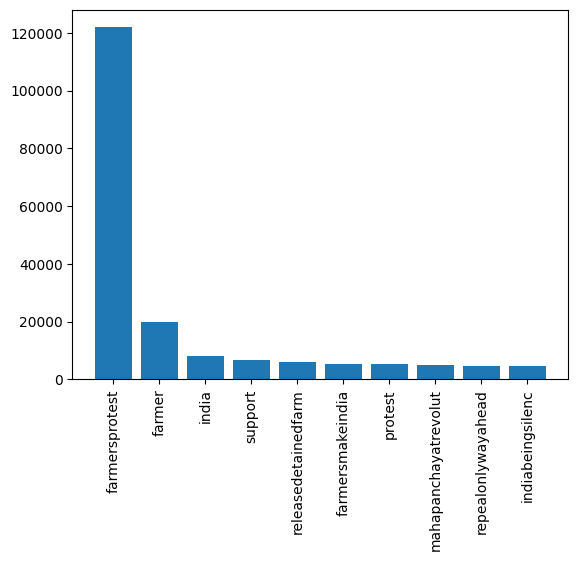

In [317]:
word_count_distribution(all_tweets_in_terms)

Average Sentence Length

In [318]:
def average_sentence_length(processed_tweets):
    lengths = [len(tweet) for tweet in processed_tweets]
    return sum(lengths) / len(lengths) if lengths else 0

In [319]:
average_sentence_length(all_tweets_in_terms)

9.6471419932372

Vocabulary size

In [320]:
def vocabulary_size(processed_terms):
    all_words = [word for tweet in processed_terms for word in tweet]
    return len(set(all_words))

In [285]:
vocabulary_size(all_tweets_in_terms)

137358

Ranking of the most retweeted tweets

In [286]:
def top_retweeted_tweets(data_tweets, top_n):
    # Sort by retweetCount in descending order and select the top N tweets
    top_retweets = data_tweets.sort_values(by='Retweets', ascending=False).head(top_n)
    
    # Extract relevant fields: content, retweet count, and tweet URL
    return top_retweets[['Tweet', 'Retweets', 'Url']]

In [287]:
top_retweeted_tweets(data_tweets, 10)

,Tweet,Retweets,Url
111329,मध्यप्रदेश में निजी व्यापारी 200 करोड़ का धान ...,7723,https://twitter.com/RakeshTikaitBKU/status/136...
7645,There's a #FarmersProtest happening in Germany...,6164,https://twitter.com/dhruv_rathee/status/136414...
89780,"disha ravi, a 21-year-old climate activist, ha...",4673,https://twitter.com/rupikaur_/status/136088206...
88911,Disha Ravi broke down in court room and told j...,3742,https://twitter.com/amaanbali/status/136090860...
111556,Farmers are so sweet. Y’all have to see this @...,3332,https://twitter.com/jedijasmin_/status/1360162...
64492,india is targeting young women to silence diss...,3230,https://twitter.com/rupikaur_/status/136179092...
108072,Bollywood has betrayed Panjab &amp; the farmer...,3182,https://twitter.com/RaviSinghKA/status/1360260...
60721,लहरों को ख़ामोश देख कर ये ना समझना कि समंदर मे...,3057,https://twitter.com/sherryontopp/status/136189...
29510,"हाँ मैं जानता हूँ कि मैं शायर नहीं, और ज़ुल्म ...",3040,https://twitter.com/sherryontopp/status/136309...
24160,"कलियुग है साहब , यहाँ झूठे को स्वीकार किया जा...",2622,https://twitter.com/sherryontopp/status/136337...


Word Clouds for the Most Frequent Words

In [288]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [289]:
from wordcloud import WordCloud

def generate_word_clouds(all_tweets_in_terms):
    # Join all the tweets into a single string
    all_words = ' '.join([' '.join(tweet) for tweet in all_tweets_in_terms])
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axes
    plt.show()

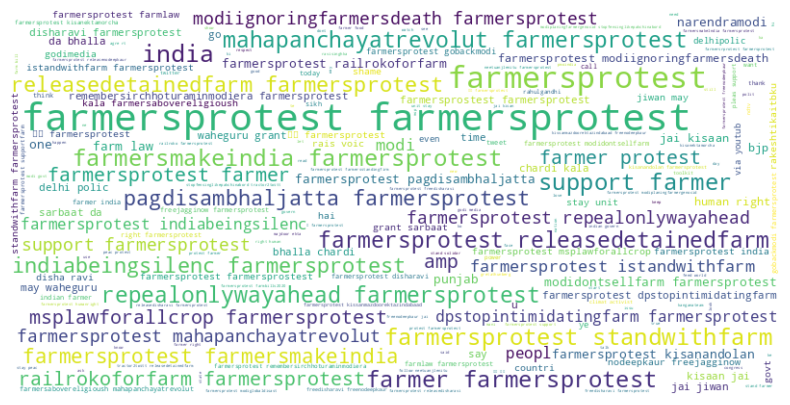

In [290]:
generate_word_clouds(all_tweets_in_terms)

Entity Recognition

In [291]:
def hashtag_cloud (data_tweets):
    # Join all the hashtags into a single string
    all_hashtags = ' '.join([' '.join(tweet) for tweet in data_tweets['Hashtags']])
    
    # Generate a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_hashtags)
    
    # Plot the word cloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axes
    plt.show()


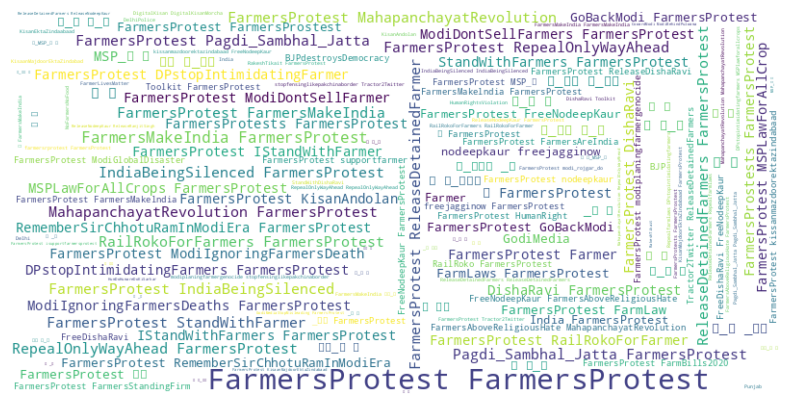

In [292]:
hashtag_cloud(data_tweets)